In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from metric import recall5
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [3]:
apply_train_df = pd.read_csv('apply_train.csv')
print(len(apply_train_df.resume_seq.unique()))
print(len(apply_train_df.recruitment_seq.unique()))
apply_train_df.sort_values(['resume_seq','recruitment_seq']).reset_index(drop=True)


8482
6695


,resume_seq,recruitment_seq
0,U00001,R04536
1,U00001,R05210
2,U00001,R05288
3,U00001,R06065
4,U00002,R01103
...,...,...
57941,U08481,R05500
57942,U08481,R06253
57943,U08482,R03633
57944,U08482,R03743


In [387]:
list(pd.DataFrame(apply_train_df.groupby('resume_seq'))[1][0]['recruitment_seq'])

['R05288', 'R05210', 'R06065', 'R04536']

In [380]:
max([len(i) for i in pd.DataFrame(apply_train_df.groupby('resume_seq'))[1]])

77

C:\Users\User\AppData\Local\Temp\ipykernel_17412\890338775.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(udata.corr())


[0.42794063]


C:\Users\User\AppData\Local\Temp\ipykernel_17412\890338775.py:52: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rdata.corr())


[0.50897918]


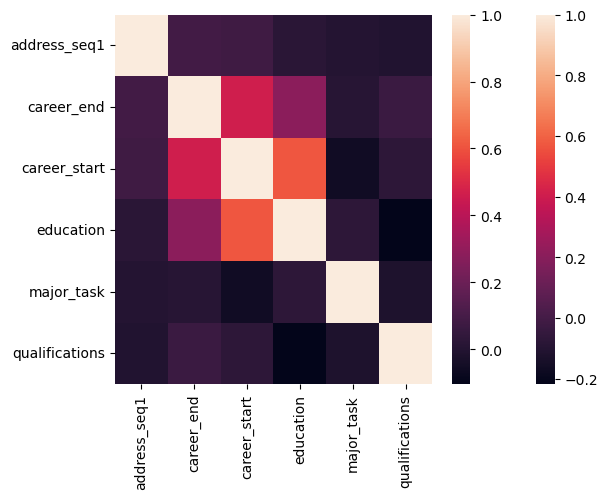

In [458]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
user_item_matrix = apply_train_df.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
# user_item_matrix[user_item_matrix > 1] = 1

udata = pd.read_csv('./resume.csv')
# udata = pd.merge(udata,pd.read_csv('./resume_certificate.csv'),how='left')
droping = ['reg_date','updated_date','graduate_date','job_code_seq2','job_code_seq3']
udata = udata.drop(droping,axis=1)

encoding = ['text_keyword','job_code_seq1','career_job_code'] # + certify encoding
udata = udata.drop(encoding,axis=1)

mg = pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)
mg = pd.read_csv('./resume_language.csv').loc[:,['resume_seq','language']].groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in udata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(udata[i]).reshape(-1,1))
    udata[i] = scaled_data
    
sns.heatmap(udata.corr())

n_components = 1  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(udata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_udata = udata['resume_seq']
udata = pd.concat([scaled_udata,pd.DataFrame(principal_components,columns=['upca1'])],axis=1)

pd.read_csv('./company.csv') # r
rdata = pd.read_csv('./recruitment.csv') # r
encoding = ['address_seq2','address_seq3','check_box_keyword','text_keyword'] # encoding, merge
rdata = rdata.drop(encoding,axis=1)
rdata = rdata.fillna(3)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in rdata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(rdata[i]).reshape(-1,1))
    rdata[i] = scaled_data
    
sns.heatmap(rdata.corr())

n_components = 1  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(rdata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_rdata = rdata['recruitment_seq']
rdata = pd.concat([scaled_rdata,pd.DataFrame(principal_components,columns=['rpca1'])],axis=1)
tp = pd.merge(pd.merge(apply_train_df,rdata),udata)
tar = pd.DataFrame(index=sorted(tp['resume_seq'].unique()),columns=sorted(tp['recruitment_seq'].unique()))
tar = tar.fillna(0)
for i in range(len(tp)):
    data = tp.loc[i,:]
    tar.loc[data['resume_seq'],data['recruitment_seq']] = abs(data['upca1'])
    
user_item_matrix = tar

# 사용자 간의 유사성 계산
user_similarity = cosine_similarity(user_item_matrix) # x, yT

# 추천 점수 계산
user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [460]:
user_similarity.shape, user_item_matrix.shape, user_predicted_scores.shape

((8482, 8482), (8482, 6695), (8482, 6695))

In [461]:
data

resume_seq           U08191
recruitment_seq      R06597
rpca1              0.150619
upca1             -0.308479
Name: 57945, dtype: object

In [462]:
df = pd.DataFrame(user_predicted_scores,columns=sorted(list(set(apply_train_df.recruitment_seq))))

# 각 행에서 최대값 5개와 해당 열의 이름을 선택하는 함수 정의
def top_n_largest_with_column_names(row, n):
    largest_values = row.nlargest(n)
    return largest_values.index.tolist()

# 최대값 5개와 열 이름 선택
selected_columns = df.apply(top_n_largest_with_column_names, args=(100,), axis=1)

print(selected_columns)
    
# sub = pd.read_csv('./sample_submission.csv')
# sub['recruitment_seq'] = answer
# sub.to_csv('./sub.csv',index=False)

0       [R04536, R05288, R05210, R06065, R01528, R0389...
1       [R01103, R05472, R02346, R06019, R01960, R0458...
2       [R01460, R03301, R04918, R00588, R01074, R0570...
3       [R03925, R04709, R02355, R00004, R01747, R0031...
4       [R00374, R00832, R03914, R05792, R03782, R0410...
                              ...                        
8477    [R03939, R02170, R02634, R03649, R03721, R0132...
8478    [R02988, R03837, R02787, R01470, R05850, R0154...
8479    [R03152, R00803, R00083, R06557, R03006, R0373...
8480    [R00225, R06253, R05500, R05246, R00021, R0166...
8481    [R06282, R03633, R03743, R04602, R04710, R0035...
Length: 8482, dtype: object


In [463]:
for i in tqdm(range(len(selected_columns))):
    for erase in list(pd.DataFrame(apply_train_df.groupby('resume_seq'))[1][i]['recruitment_seq']):
        if erase in selected_columns[i]:
            selected_columns[i].remove(erase)
            
answer = []
for i in list(selected_columns):
    answer.extend(i[:5])

100%|████████████████████████████████████████████████████████████████████████████| 8482/8482 [1:34:13<00:00,  1.50it/s]


In [464]:
sub = pd.read_csv('./sample_submission.csv')
sub['recruitment_seq'] = answer
sub.to_csv('./sub.csv',index=False)

In [465]:
pd.read_csv('./company.csv') # r
pd.read_csv('./recruitment.csv') # r
pd.read_csv('./resume.csv') # u
pd.read_csv('./resume_certificate.csv') # u
pd.read_csv('./resume_education.csv') # u
pd.read_csv('./resume_language.csv') # u

,resume_seq,language,exam_name,score
0,U01774,2,4,742.42
1,U04892,2,4,888.89
2,U01859,2,4,500.00
3,U02475,2,4,500.00
4,U03776,4,5,595.96
...,...,...,...,...
864,U04964,2,11,400.00
865,U02950,2,4,843.43
866,U05922,2,2,500.00
867,U03827,2,4,883.84


In [96]:
print(len(pd.read_csv('./company.csv'))) # r
print(len(pd.read_csv('./recruitment.csv'))) # r

r = pd.merge(pd.read_csv('./recruitment.csv'),pd.read_csv('./company.csv'),how='left').sort_values('recruitment_seq').reset_index(drop=True)
[i.split(';') for i in r['check_box_keyword']]
r

2377
6695


,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


In [59]:
pd.read_csv('./resume.csv')
pd.read_csv('./resume_certificate.csv')
pd.read_csv('./resume_education.csv')
pd.read_csv('./resume_language.csv')
print(len(pd.read_csv('./resume.csv')))
print(len(pd.read_csv('./resume_certificate.csv')))
print(len(pd.read_csv('./resume_education.csv')))
print(len(pd.read_csv('./resume_language.csv')))

8482
12975
8482
869


In [64]:
pd.merge(pd.read_csv('./resume.csv'),pd.read_csv('./resume_education.csv'))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   reg_date               8482 non-null   object 
 2   updated_date           8482 non-null   object 
 3   degree                 8482 non-null   int64  
 4   graduate_date          8482 non-null   int64  
 5   hope_salary            8482 non-null   float64
 6   last_salary            8482 non-null   float64
 7   text_keyword           8287 non-null   object 
 8   job_code_seq1          8482 non-null   object 
 9   job_code_seq2          500 non-null    object 
 10  job_code_seq3          187 non-null    object 
 11  career_month           8482 non-null   int64  
 12  career_job_code        7724 non-null   object 
 13  hischool_type_seq      8482 non-null   int64  
 14  hischool_special_type  8482 non-null   object 
 15  hisc

In [453]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
# import seaborn as sns

# udata = pd.read_csv('./resume.csv')
# # udata = pd.merge(udata,pd.read_csv('./resume_certificate.csv'),how='left')
# droping = ['reg_date','updated_date','graduate_date','job_code_seq2','job_code_seq3']
# udata = udata.drop(droping,axis=1)

# encoding = ['text_keyword','job_code_seq1','career_job_code'] # + certify encoding
# udata = udata.drop(encoding,axis=1)

# mg = pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
# udata = pd.merge(udata,mg,how='left').fillna(0)
# mg = pd.read_csv('./resume_language.csv').loc[:,['resume_seq','language']].groupby('resume_seq').count().reset_index()
# udata = pd.merge(udata,mg,how='left').fillna(0)


# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the data
# for i in udata.columns[1:]:
#     scaled_data = scaler.fit_transform(np.array(udata[i]).reshape(-1,1))
#     udata[i] = scaled_data
    
# sns.heatmap(udata.corr())

# n_components = 1  # Number of principal components to keep
# pca = PCA(n_components)
# principal_components = pca.fit_transform(udata.iloc[:,1:])
# print(pca.explained_variance_ratio_)

# scaled_udata = udata['resume_seq']
# udata = pd.concat([scaled_udata,pd.DataFrame(principal_components,columns=['upca1'])],axis=1)

# udata

In [452]:
# pd.read_csv('./company.csv') # r
# rdata = pd.read_csv('./recruitment.csv') # r
# encoding = ['address_seq2','address_seq3','check_box_keyword','text_keyword'] # encoding, merge
# rdata = rdata.drop(encoding,axis=1)
# rdata = rdata.fillna(3)


# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the data
# for i in rdata.columns[1:]:
#     scaled_data = scaler.fit_transform(np.array(rdata[i]).reshape(-1,1))
#     rdata[i] = scaled_data
    
# sns.heatmap(rdata.corr())

# n_components = 1  # Number of principal components to keep
# pca = PCA(n_components)
# principal_components = pca.fit_transform(rdata.iloc[:,1:])
# print(pca.explained_variance_ratio_)

# scaled_rdata = rdata['recruitment_seq']
# rdata = pd.concat([scaled_rdata,pd.DataFrame(principal_components,columns=['rpca1'])],axis=1)

# rdata

In [451]:
# tp = pd.merge(pd.merge(apply_train_df,rdata),udata)
# tar = pd.DataFrame(index=sorted(tp['resume_seq'].unique()),columns=sorted(tp['recruitment_seq'].unique()))
# tar = tar.fillna(0)
# for i in range(len(tp)):
#     data = tp.loc[i,:]
#     tar.loc[data['resume_seq'],data['recruitment_seq']] = abs(data['rpca1'])
    
# tar

In [468]:
udata.sort_values('resume_seq').reset_index(drop=True) # 모든 값을 채운 user-item matrix 만들어서 eda 

,resume_seq,upca1
0,U00001,-0.101947
1,U00002,-0.239594
2,U00003,-0.240667
3,U00004,-0.338235
4,U00005,-0.305792
...,...,...
8477,U08478,-0.035586
8478,U08479,0.048651
8479,U08480,-0.365477
8480,U08481,-0.103398


C:\Users\User\AppData\Local\Temp\ipykernel_17412\3551436739.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(udata.corr())


[0.42794063 0.18142266]


,resume_seq,upca1,upca2
0,U00606,0.209503,0.070064
1,U00509,0.069493,-0.241749
2,U02012,0.206703,0.090490
3,U04599,-0.139470,-0.019403
4,U07573,-0.229207,0.170333
...,...,...,...
8477,U04890,0.353037,-0.362741
8478,U05910,-0.116491,0.290338
8479,U01468,-0.307805,-0.022561
8480,U05315,-0.290986,-0.037922


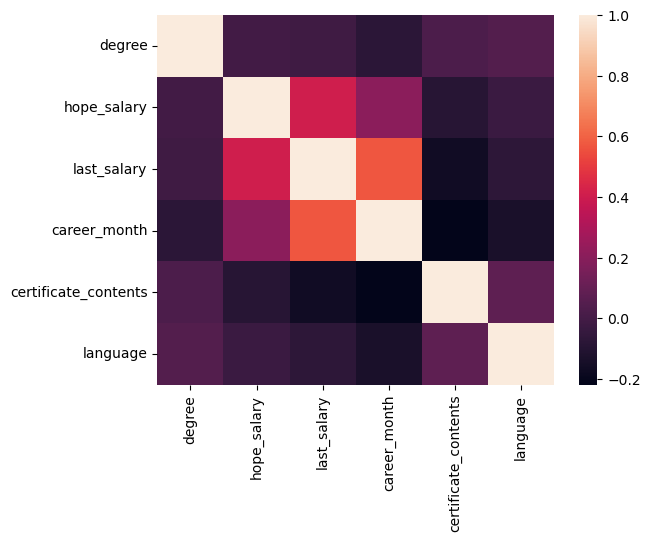

In [518]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

udata = pd.read_csv('./resume.csv')
# udata = pd.merge(udata,pd.read_csv('./resume_certificate.csv'),how='left')
droping = ['reg_date','updated_date','graduate_date','job_code_seq2','job_code_seq3']
udata = udata.drop(droping,axis=1)

encoding = ['text_keyword','job_code_seq1','career_job_code'] # + certify encoding
udata = udata.drop(encoding,axis=1)

mg = pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)
mg = pd.read_csv('./resume_language.csv').loc[:,['resume_seq','language']].groupby('resume_seq').count().reset_index()
udata = pd.merge(udata,mg,how='left').fillna(0)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in udata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(udata[i]).reshape(-1,1))
    udata[i] = scaled_data
    
sns.heatmap(udata.corr())

n_components = 2  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(udata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_udata = udata['resume_seq']
udata = pd.concat([scaled_udata,pd.DataFrame(principal_components,columns=['upca1','upca2'])],axis=1)

udata

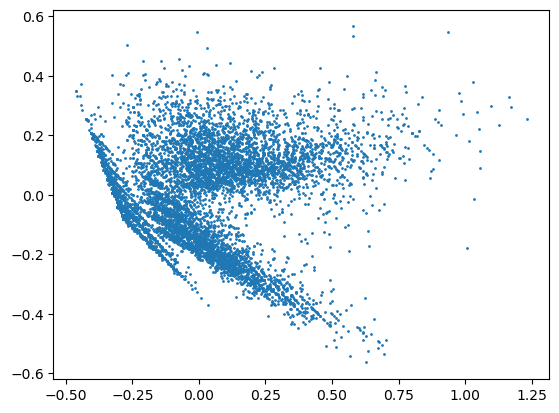

In [480]:
import matplotlib.pyplot as plt
plt.scatter(udata['upca1'],udata['upca2'],s=1)

C:\Users\User\AppData\Local\Temp\ipykernel_17412\3290528484.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rdata.corr())


[0.50897918 0.30221199]


,recruitment_seq,rpca1,rpca2
0,R02264,0.212840,0.216749
1,R06317,0.150619,-0.053744
2,R04017,0.150619,-0.053744
3,R02865,0.099490,-0.298235
4,R04890,-0.389869,-0.195717
...,...,...,...
6690,R03678,0.150619,-0.053744
6691,R04593,0.201749,0.190747
6692,R03252,0.150619,-0.053744
6693,R05130,-0.389869,-0.195717


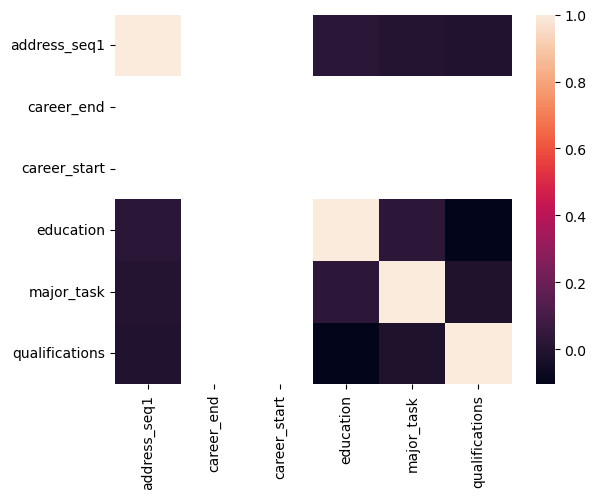

In [503]:
pd.read_csv('./company.csv') # r
rdata = pd.read_csv('./recruitment.csv') # r
encoding = ['address_seq2','address_seq3','check_box_keyword','text_keyword'] # encoding, merge
rdata = rdata.drop(encoding,axis=1)
rdata = rdata.fillna(3)


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
for i in rdata.columns[1:]:
    scaled_data = scaler.fit_transform(np.array(rdata[i]).reshape(-1,1))
    rdata[i] = scaled_data
    
sns.heatmap(rdata.corr())

n_components = 2  # Number of principal components to keep
pca = PCA(n_components)
principal_components = pca.fit_transform(rdata.iloc[:,1:])
print(pca.explained_variance_ratio_)

scaled_rdata = rdata['recruitment_seq']
rdata = pd.concat([scaled_rdata,pd.DataFrame(principal_components,columns=['rpca1','rpca2'])],axis=1)

rdata

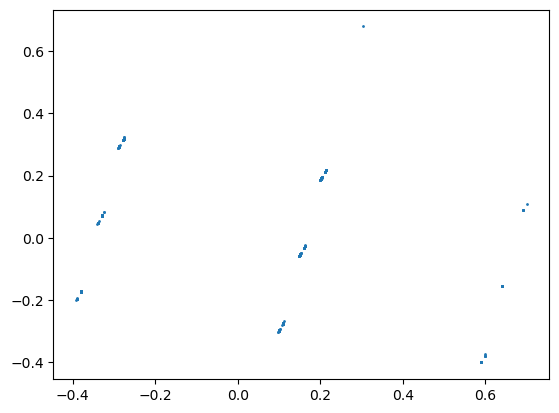

In [504]:
import matplotlib.pyplot as plt
plt.scatter(rdata['rpca1'],rdata['rpca2'],s=1)

In [514]:
# 예제 데이터 생성
np.random.seed(0)
data = rdata.loc[:,['rpca1','rpca2']]

# K-Means 모델 생성
kmeans = KMeans(n_clusters=10, random_state=0)

# 데이터를 10개 그룹으로 클러스터링
kmeans.fit(data)

# 클러스터 중심 확인
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# 각 데이터 포인트의 클러스터 할당 확인
labels = kmeans.labels_
print("Cluster Assignments:")
print(labels)

rdata['group_code'] = labels
rdata['group_code'].value_counts()

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
[[ 0.20234805  0.19214491]
 [-0.33829143  0.04982177]
 [ 0.09991035 -0.29725401]
 [ 0.15116146 -0.05247711]
 [-0.38946075 -0.19476264]
 [-0.28695683  0.29479075]
 [ 0.59167605 -0.39412565]
 [ 0.6399786  -0.1562625 ]
 [ 0.69264875  0.09184012]
 [ 0.30400861  0.67972927]]
Cluster Assignments:
[0 3 3 ... 3 4 3]


3    1882
0    1627
2     982
1     964
4     645
5     555
6      17
7      16
8       6
9       1
Name: group_code, dtype: int64

In [538]:
# 예제 데이터 생성
np.random.seed(0)
data = udata.loc[:,['upca1','upca2']]

# K-Means 모델 생성
kmeans = KMeans(n_clusters=3, random_state=0)

# 데이터를 10개 그룹으로 클러스터링
kmeans.fit(data)

# 클러스터 중심 확인
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# 각 데이터 포인트의 클러스터 할당 확인
labels = kmeans.labels_
print("Cluster Assignments:")
print(labels)

udata['group_code'] = labels
udata['group_code'].value_counts()

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
[[ 0.25351351  0.13506989]
 [-0.18827641  0.01647319]
 [ 0.12903816 -0.22502497]]
Cluster Assignments:
[0 2 0 ... 1 1 1]


1    4367
0    2373
2    1742
Name: group_code, dtype: int64

In [540]:
tp = apply_train_df.set_index('resume_seq')
len(tp.loc[list(udata[udata['group_code'] == 1]['resume_seq']),:]['recruitment_seq'].unique())

6110

In [85]:
apply_train_df.sort_values('resume_seq')

,resume_seq,recruitment_seq
11989,U00001,R05210
342,U00001,R05288
51174,U00001,R04536
28858,U00001,R06065
50591,U00002,R01103
...,...,...
13950,U08481,R00225
22895,U08481,R05500
33843,U08482,R03633
54343,U08482,R03743


In [114]:
tp = pd.read_csv('./recruitment.csv')
req_list = [list(i['recruitment_seq']) for i in pd.DataFrame(apply_train_df.groupby('resume_seq'))[1]]
target = 13
ans = pd.DataFrame()
for i in [tp[tp['recruitment_seq'] == i] for i in req_list[target]]:
    ans = pd.concat([ans,i])
    
reverse_tracking = [eval(i[2:].lstrip('0')) for i in ans['recruitment_seq']]
ans

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword
2826,R05492,3.0,NaN,NaN,0,0,2204;2205;2707,3,2,2,NaN
5388,R02412,3.0,NaN,NaN,0,0,2507;2707,2,2,2,NaN
2830,R04074,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN
2876,R05472,3.0,NaN,NaN,0,0,2101;2108;2201;2507;2707;2810,3,2,1,NaN
4061,R03312,3.0,NaN,NaN,0,0,2501;2507,2,8,2,NaN
3869,R04461,3.0,NaN,NaN,0,0,2501;2507;2707,4,8,1,NaN
5774,R02715,3.0,NaN,NaN,0,0,2507;2707,2,2,2,NaN
4492,R06282,3.0,NaN,NaN,0,0,2101;2108;2109;2201;2203;2204;2205;2302;2507;2707,2,2,2,NaN
3807,R05601,3.0,NaN,NaN,0,0,2501;2507;2703;2707,4,2,2,NaN
2488,R06216,3.0,NaN,NaN,0,0,2501;2507;2703;2707,4,2,1,NaN


In [115]:
# data merging : reuserble
# rdata = pd.merge(pd.read_csv('./resume.csv')
#          ,pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
#          ,on='resume_seq',how='left').sort_values('resume_seq')
# rdata = pd.merge(rdata,pd.read_csv('./resume_education.csv'),on='resume_seq')
rdata = pd.read_csv('./resume.csv')
resu_list = [list(i['resume_seq']) for i in pd.DataFrame(apply_train_df.groupby('recruitment_seq'))[1]]
ans = pd.DataFrame()

for target in reverse_tracking:
#target = 5210
    target -= 1
    for i in [rdata[rdata['resume_seq'] == i] for i in resu_list[target]]:
        ans = pd.concat([ans,i])
    
tracking = [eval(i[2:].lstrip('0')) for i in ans['resume_seq'].unique()]
tracking = tracking[1:]

In [116]:
ans

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
84,U00014,2020-02-09,2020-12-12,4,2014,2300.0,2900.0,여성복디자이너,재료·화학·섬유·의복,NaN,NaN,12,섬유;봉제;가방;의류
5803,U04239,2017-08-25,2020-05-18,4,2011,0.0,0.0,VMD,재료·화학·섬유·의복,NaN,NaN,28,섬유;봉제;가방;의류
311,U00855,2019-08-10,2020-05-13,4,2013,0.0,0.0,영업;디스플레이,재료·화학·섬유·의복,NaN,NaN,15,디자인;CAD;설계
4771,U05660,2009-04-04,2020-04-04,4,2001,0.0,0.0,VMD,재료·화학·섬유·의복,NaN,NaN,137,섬유;봉제;가방;의류
7615,U02830,2010-11-21,2020-05-19,4,2005,3900.0,3700.0,VMD,재료·화학·섬유·의복,NaN,NaN,96,섬유;봉제;가방;의류
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,U07274,2012-01-06,2020-04-26,4,2008,0.0,4900.0,캐주얼디자이너;영캐주얼디자이너;여성복디자이너;우븐디자이너,재료·화학·섬유·의복,NaN,NaN,132,섬유;봉제;가방;의류
84,U00014,2020-02-09,2020-12-12,4,2014,2300.0,2900.0,여성복디자이너,재료·화학·섬유·의복,NaN,NaN,12,섬유;봉제;가방;의류
3665,U08175,2019-01-08,2020-04-06,4,2003,0.0,0.0,우븐디자이너팀장급,재료·화학·섬유·의복,NaN,NaN,144,섬유;봉제;가방;의류
3299,U00254,2013-01-12,2020-06-23,4,2003,0.0,4300.0,의상디자이너,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류


In [127]:
tp = pd.read_csv('./recruitment.csv')
req_list = [list(i['recruitment_seq']) for i in pd.DataFrame(apply_train_df.groupby('resume_seq'))[1]]
# target = tracking
# ans = pd.DataFrame()

# for tar in target:
#     for i in [tp[tp['recruitment_seq'] == i] for i in req_list[tar]]:
#         ans = pd.concat([ans,i])
ans = []
for i in req_list:
    ans.extend(i)
reverse_tracking = [eval(i[2:].lstrip('0')) for i in ans]
# ans.groupby('recruitment_seq').count().sort_values('address_seq1',ascending=False)[:10]

In [132]:
import collections
collections.Counter(reverse_tracking)
len(reverse_tracking)
req_list

[['R05288', 'R05210', 'R06065', 'R04536'],
 ['R06019',
  'R01730',
  'R01960',
  'R05472',
  'R04588',
  'R02946',
  'R02346',
  'R01103'],
 ['R01460', 'R04918', 'R03301'],
 ['R00004',
  'R02899',
  'R01068',
  'R02003',
  'R02355',
  'R04709',
  'R00564',
  'R06658',
  'R05367',
  'R01511',
  'R00312',
  'R01747',
  'R01825',
  'R04166',
  'R03925',
  'R04891',
  'R05341'],
 ['R03914', 'R00832', 'R00374'],
 ['R02944',
  'R01489',
  'R06501',
  'R05982',
  'R05748',
  'R02551',
  'R03139',
  'R01745',
  'R04087',
  'R03864',
  'R02029',
  'R06190',
  'R05285',
  'R04388',
  'R02244',
  'R04458',
  'R05369',
  'R06104',
  'R02974',
  'R00916',
  'R03946',
  'R01769',
  'R03331',
  'R02995',
  'R00554',
  'R05111',
  'R00925',
  'R05040',
  'R02008',
  'R05666',
  'R02262',
  'R05767',
  'R02017',
  'R04059'],
 ['R02793', 'R00635', 'R03749'],
 ['R02023',
  'R04783',
  'R03848',
  'R01625',
  'R05370',
  'R05328',
  'R03886',
  'R00663',
  'R06637',
  'R03926',
  'R05009',
  'R02882',
  '

In [120]:
req_list

[['R05288', 'R05210', 'R06065', 'R04536'],
 ['R06019',
  'R01730',
  'R01960',
  'R05472',
  'R04588',
  'R02946',
  'R02346',
  'R01103'],
 ['R01460', 'R04918', 'R03301'],
 ['R00004',
  'R02899',
  'R01068',
  'R02003',
  'R02355',
  'R04709',
  'R00564',
  'R06658',
  'R05367',
  'R01511',
  'R00312',
  'R01747',
  'R01825',
  'R04166',
  'R03925',
  'R04891',
  'R05341'],
 ['R03914', 'R00832', 'R00374'],
 ['R02944',
  'R01489',
  'R06501',
  'R05982',
  'R05748',
  'R02551',
  'R03139',
  'R01745',
  'R04087',
  'R03864',
  'R02029',
  'R06190',
  'R05285',
  'R04388',
  'R02244',
  'R04458',
  'R05369',
  'R06104',
  'R02974',
  'R00916',
  'R03946',
  'R01769',
  'R03331',
  'R02995',
  'R00554',
  'R05111',
  'R00925',
  'R05040',
  'R02008',
  'R05666',
  'R02262',
  'R05767',
  'R02017',
  'R04059'],
 ['R02793', 'R00635', 'R03749'],
 ['R02023',
  'R04783',
  'R03848',
  'R01625',
  'R05370',
  'R05328',
  'R03886',
  'R00663',
  'R06637',
  'R03926',
  'R05009',
  'R02882',
  '

In [98]:
tp

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword
0,R02264,3.0,NaN,NaN,0,0,2507;2707;2810,4,8,1,NaN
1,R06317,3.0,NaN,NaN,0,0,2204;2205;2707,3,2,1,NaN
2,R04017,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,1,NaN
3,R02865,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,1,NaN
4,R04890,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6690,R03678,3.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707,3,2,1,NaN
6691,R04593,3.0,NaN,NaN,0,0,2201;2204;2205;2707,4,2,1,NaN
6692,R03252,3.0,NaN,NaN,0,0,2109,3,2,1,NaN
6693,R05130,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,2,NaN


In [209]:
def finding_second_recuruitment(target):
    tp = pd.read_csv('./recruitment.csv').iloc[:,:2]
    req_list = [list(i['recruitment_seq']) for i in pd.DataFrame(apply_train_df.groupby('resume_seq'))[1]]
    # target = 2
    ans = pd.DataFrame()
    for i in [tp[tp['recruitment_seq'] == i] for i in req_list[target]]:
        ans = pd.concat([ans,i])

    reverse_tracking = [eval(i[2:].lstrip('0')) for i in ans['recruitment_seq']]

    rdata = pd.read_csv('./resume.csv').iloc[:,:2]
    resu_list = [list(i['resume_seq']) for i in pd.DataFrame(apply_train_df.groupby('recruitment_seq'))[1]]
    ans = pd.DataFrame()

    for target in reverse_tracking:
    #target = 5210
        target -= 1
        for i in [rdata[rdata['resume_seq'] == i] for i in resu_list[target]]:
            ans = pd.concat([ans,i])

    tracking = [eval(i[2:].lstrip('0')) for i in ans['resume_seq'].unique()]
    tracking = tracking[1:]

    tp = pd.read_csv('./recruitment.csv').iloc[:,:2]
    req_list = [list(i['recruitment_seq']) for i in pd.DataFrame(apply_train_df.groupby('resume_seq'))[1]]
    target = tracking
    ans = pd.DataFrame()

    for tar in target:
        for i in [tp[tp['recruitment_seq'] == i] for i in req_list[tar]]:
            ans = pd.concat([ans,i])

    reverse_tracking = [eval(i[2:].lstrip('0')) for i in ans['recruitment_seq']]
    return ans.groupby('recruitment_seq').count().sort_values('address_seq1',ascending=False).index

relation = [finding_second_recuruitment(i) for i in tqdm(range(6695))]



  0%|                                                                              | 8/6695 [01:06<15:23:50,  8.29s/it]


  0%|                                                                               | 1/6695 [00:03<6:18:14,  3.39s/it]

  0%|                                                                               | 2/6695 [00:06<5:57:22,  3.20s/it]

  0%|                                                                               | 3/6695 [00:09<5:59:25,  3.22s/it]

  0%|                                                                               | 4/6695 [00:14<7:07:22,  3.83s/it]

  0%|                                                                               | 5/6695 [00:16<6:06:35,  3.29s/it]

  0%|                                                                               | 6/6695 [00:21<7:03:59,  3.80s/it]

  0%|                                                                               | 7/6695 [00:24<6:34:56,  3.54s/it]

KeyboardInterrupt: 

In [81]:
finding_second_recuruitment(0)

Index(['R02166', 'R02523', 'R04073', 'R04632', 'R04420', 'R05425', 'R00036',
       'R04309', 'R04319', 'R04333',
       ...
       'R02186', 'R02207', 'R02233', 'R02264', 'R02289', 'R02341', 'R02426',
       'R02432', 'R02462', 'R06692'],
      dtype='object', name='recruitment_seq', length=239)

In [67]:
# target = pd.merge(pd.read_csv('./resume.csv')
#          ,pd.read_csv('./resume_certificate.csv').groupby('resume_seq').count().reset_index()
#          ,on='resume_seq',how='left').sort_values('resume_seq')
# target = pd.merge(target,pd.read_csv('./resume_education.csv'),on='resume_seq')
# target

In [185]:
def make_format(target):
    # target = 4
    tar = str(target)
    return 'U'+(5-len(tar))*'0'+tar

In [ ]:
from collections import Counter
# target = 4

def make_second_matrix(target):
    second = pd.DataFrame(apply_train_df.groupby('resume_seq'))[1][target]['recruitment_seq'].to_list()
    ans = [apply_train_df[apply_train_df['recruitment_seq'] == i]['resume_seq'].to_list() for i in second]
    answer = []
    for i in ans:
        answer.extend(i)
    k = list(Counter(answer).keys())
    v = list(Counter(answer).values())
    tp = [[make_format(target),i,j] for i,j in zip(k,v)]
    return pd.DataFrame(tp,columns=['resume_seq','recruitment_seq','count'])
# answer = list(set(answer))
# answer.sort()
# answer = answer[1:]
# answer

answer = pd.DataFrame(columns=['resume_seq','recruitment_seq','count'])
for i in tqdm(range(8482)):
    answer = pd.concat([answer,make_second_matrix(i)])
answer

  3%|██▎                                                                            | 250/8482 [01:49<54:42,  2.51it/s]

In [225]:
tp = answer.sort_values(['resume_seq','count'],ascending=True).reset_index(drop=True)
tp['count'] = tp['count'].astype('int')
def top_n_largest(group, n=5):
    return group.nlargest(n, 'count')
tp.groupby('resume_seq').apply(top_n_largest, n=5)

  0%|                                                                          | 7/6695 [1:00:28<963:05:56, 518.41s/it]


resume_seq recruitment_seq  count
resume_seq                                         
U00001     46         U00001          R00002      6
           40         U00001          R04675      2
           41         U00001          R04642      2
           42         U00001          R03385      2
           43         U00001          R05215      2
...                      ...             ...    ...
U06694     681144     U06694          R06695      9
           681143     U06694          R03118      3
           681137     U06694          R03475      2
           681138     U06694          R00977      2
           681139     U06694          R01820      2

[33461 rows x 3 columns]

In [226]:
pd.read_csv('./sample_submission.csv')

,resume_seq,recruitment_seq
0,U00001,R03134
1,U00001,R00465
2,U00001,R01931
3,U00001,R01607
4,U00001,R06059
...,...,...
42405,U08482,R03134
42406,U08482,R00465
42407,U08482,R01931
42408,U08482,R01607


In [248]:
target = 8481
second = pd.DataFrame(apply_train_df.groupby('resume_seq'))[1][target]['recruitment_seq'].to_list()
ans = [apply_train_df[apply_train_df['recruitment_seq'] == i]['resume_seq'].to_list() for i in second]
answer = []
for i in ans:
    answer.extend(i)
k = list(Counter(answer).keys())
v = list(Counter(answer).values())
tp = [[make_format(target),i,j] for i,j in zip(k,v)]
tp

[['U08481', 'U00819', 1],
 ['U08481', 'U02408', 1],
 ['U08481', 'U01405', 1],
 ['U08481', 'U05897', 1],
 ['U08481', 'U00472', 1],
 ['U08481', 'U02103', 2],
 ['U08481', 'U01533', 1],
 ['U08481', 'U02201', 1],
 ['U08481', 'U08482', 3],
 ['U08481', 'U00038', 1],
 ['U08481', 'U03020', 1],
 ['U08481', 'U04798', 1],
 ['U08481', 'U00602', 1],
 ['U08481', 'U07023', 2],
 ['U08481', 'U07995', 1],
 ['U08481', 'U02125', 1],
 ['U08481', 'U05318', 1],
 ['U08481', 'U04501', 1],
 ['U08481', 'U05188', 2],
 ['U08481', 'U02166', 2],
 ['U08481', 'U02524', 1],
 ['U08481', 'U01541', 1],
 ['U08481', 'U08107', 1],
 ['U08481', 'U00014', 1],
 ['U08481', 'U05182', 1],
 ['U08481', 'U07809', 2],
 ['U08481', 'U00285', 1],
 ['U08481', 'U02246', 1],
 ['U08481', 'U03685', 1],
 ['U08481', 'U02965', 1],
 ['U08481', 'U02299', 1],
 ['U08481', 'U03304', 1],
 ['U08481', 'U02270', 1],
 ['U08481', 'U05024', 1],
 ['U08481', 'U04161', 1],
 ['U08481', 'U07184', 1],
 ['U08481', 'U01838', 1],
 ['U08481', 'U04762', 1]]

In [244]:
pd.DataFrame(apply_train_df.groupby('resume_seq'))[1][0]

,resume_seq,recruitment_seq
342,U00001,R05288
11989,U00001,R05210
28858,U00001,R06065
51174,U00001,R04536
